### 파라미터

In [39]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

### 데이터 준비 및 전처리

In [40]:
from tensorflow.keras import datasets
import numpy as np

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

### 변형된 인코더

이제 단순한 2D벡터가 아닌 정규 분포에 매핑합니다.

In [41]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, optimizers, metrics, losses


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [42]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 64)  │     18,496 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2048)      │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_3          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
decoder_output = layers.Conv2D(1, (3, 3), strides=1, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### VAE

기존 재구성 손실 함수에서 추가로 KL 손실 함수 및, 총손실 함수가 존재.

In [44]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
        
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1+z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss+kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1,))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def get_config(self):
        return {}

In [45]:
vae = VAE(encoder, decoder)
opt = optimizers.Adam(learning_rate=0.0003)
vae.compile(optimizer= opt)

In [47]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=(x_test, x_test),
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - kl_loss: 3.4504 - reconstruction_loss: 210.2165 - total_loss: 213.6670 - val_kl_loss: 5.0184 - val_loss: 145.2844 - val_reconstruction_loss: 140.2660
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - kl_loss: 5.0016 - reconstruction_loss: 133.6615 - total_loss: 138.6631 - val_kl_loss: 5.1340 - val_loss: 138.9386 - val_reconstruction_loss: 133.8045
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - kl_loss: 4.9861 - reconstruction_loss: 130.4066 - total_loss: 135.3927 - val_kl_loss: 5.0510 - val_loss: 137.8799 - val_reconstruction_loss: 132.8289
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - kl_loss: 5.0137 - reconstruction_loss: 129.1365 - total_loss: 134.1503 - val_kl_loss: 4.9741 - val_loss: 136.7866 - val_reconstruction_loss: 131.8125
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - kl_loss: 5.0578 - reconstruction_loss: 128.1023 - total_loss: 133.1601 - val_kl_loss: 5.1810 - val_loss: 136.0516 - val_recon

In [48]:
vae.save('./models/vae.keras')
encoder.save('./models/vae_encoder.keras')
decoder.save('./models/vae_decoder.keras')

### 인코더를 통한 잠재 공간 확인, 디코더를 사용하여 생성

In [53]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [54]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


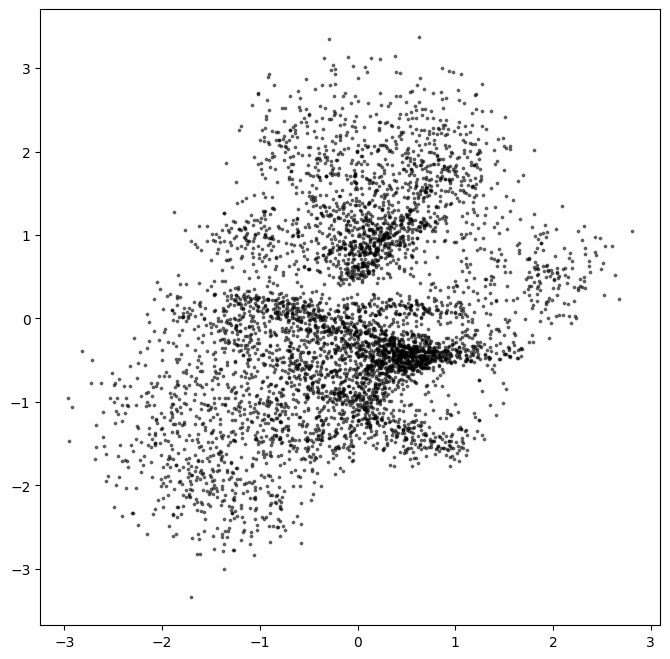

In [55]:
import matplotlib.pyplot as plt

figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [56]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [57]:
from scipy.stats import norm

reconstructions = decoder.predict(z_sample)
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


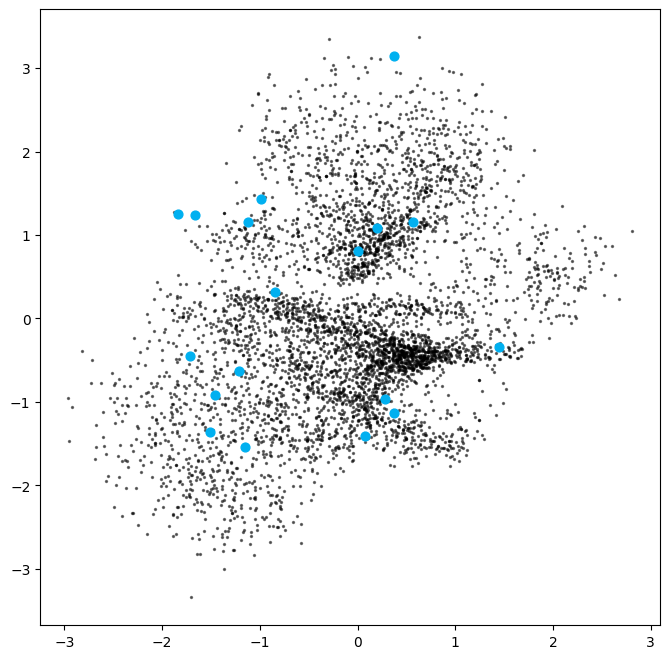

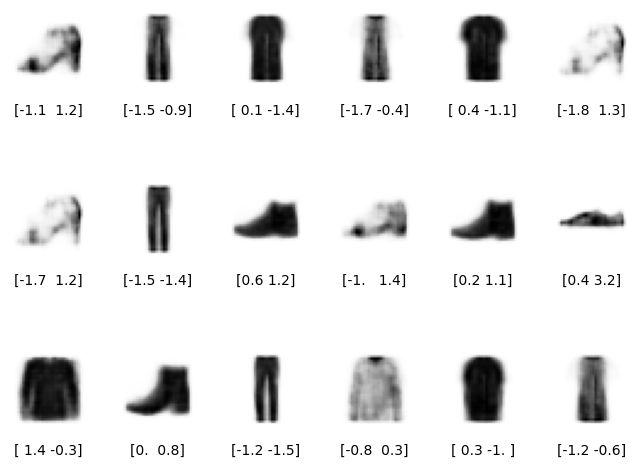

In [58]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드를 추가합니다.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")